In [1]:
import os

In [ ]:
%pwd

In [3]:
os.chdir("../")

**For Entity**

In [31]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir:Path
    data_dir:Path

**For Configuration**

In [32]:
from src.mlProject.constants import *
from src.mlProject.utils.common import read_yaml,create_directories

In [38]:
class ConfigurationManager:
    def __init__(self,
                 config_filepath=CONFIG_FILE_PATH,
                 param_filepath=PARAM_FILE_PATH,
                 schema_filepath=SCHEMA_FILE_PATH
                 ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(param_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_dir=config.data_dir,
        )

        return data_transformation_config


**For Component**

In [70]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mlProject import logger
from sklearn.model_selection import train_test_split


In [68]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        self.data = pd.read_csv(self.config.data_dir)

    def CheckEda(self):
        try:
            df = self.data.copy()  # work on copy to keep original safe

            # 1. Missing values check
            missing = df.isnull().sum()
            logger.info("Missing values per column:\n%s", missing)
            print("Missing values per column:\n", missing)

            # 2. Duplicate rows check
            duplicates = df.duplicated().sum()
            logger.info("Number of duplicate rows: %d", duplicates)
            print("Number of duplicate rows:", duplicates)

            # 3. Categorical columns detection and encoding (if any)
            cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            if cat_cols:
                logger.info("Categorical columns detected: %s", cat_cols)
                print("Categorical columns detected:", cat_cols)
                # Convert categorical columns to numeric using pd.get_dummies (one-hot encoding)
                df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
            else:
                logger.info("No categorical columns detected.")
                print("No categorical columns detected.")

            # 5. Plot histograms of original features
            df.hist(figsize=(12, 10), bins=30)
            plt.suptitle("Feature Distributions Before Scaling")
            plt.tight_layout()
            plt.show()

            # 6. Scaling numeric features (excluding target)
            target_col = 'quality'
            features = df.drop(columns=[target_col])
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(features)

            df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
            df_scaled[target_col] = df[target_col].values

            # 7. Log mean and std of scaled features
            logger.info("Scaled features mean:\n%s", df_scaled.mean())
            logger.info("Scaled features std dev:\n%s", df_scaled.std())
            print("Scaled features mean:\n", df_scaled.mean())
            print("Scaled features std dev:\n", df_scaled.std())

            # 8. Plot histograms after scaling
            df_scaled.drop(columns=[target_col]).hist(figsize=(12, 10), bins=30)
            plt.suptitle("Feature Distributions After Scaling")
            plt.tight_layout()
            plt.show()

            # 9. Correlation heatmap on scaled data
            plt.figure(figsize=(12, 10))
            corr = df_scaled.corr()
            sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
            plt.title("Correlation Heatmap")
            plt.show()

            return df_scaled  # return scaled data for downstream use
        except Exception as e:
            raise e

    def train_test_spliting(self):
        try:
            data = self.data
            train, test = train_test_split(data, test_size=0.2)

            train.to_csv(os.path.join(self.config.root_dir, "train.csv"),index = False)
            test.to_csv(os.path.join(self.config.root_dir, "test.csv"),index = False)

            logger.info("Splited data into training and test sets")
            logger.info(train.shape)
            logger.info(test.shape)

            print(train.shape)
            print(test.shape)
            
        except Exception as e:
            raise e

2025-05-22 14:20:27,496 : INFO : common : yaml file: config\config.yaml loaded successfully
2025-05-22 14:20:27,498 : INFO : common : yaml file: params.yaml loaded successfully
2025-05-22 14:20:27,503 : INFO : common : yaml file: schema.yaml loaded successfully
2025-05-22 14:20:27,506 : INFO : common : created directory at: artifacts
2025-05-22 14:20:27,508 : INFO : common : created directory at: artifacts/data_transformation
2025-05-22 14:20:27,519 : INFO : 3149788957 : Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur di

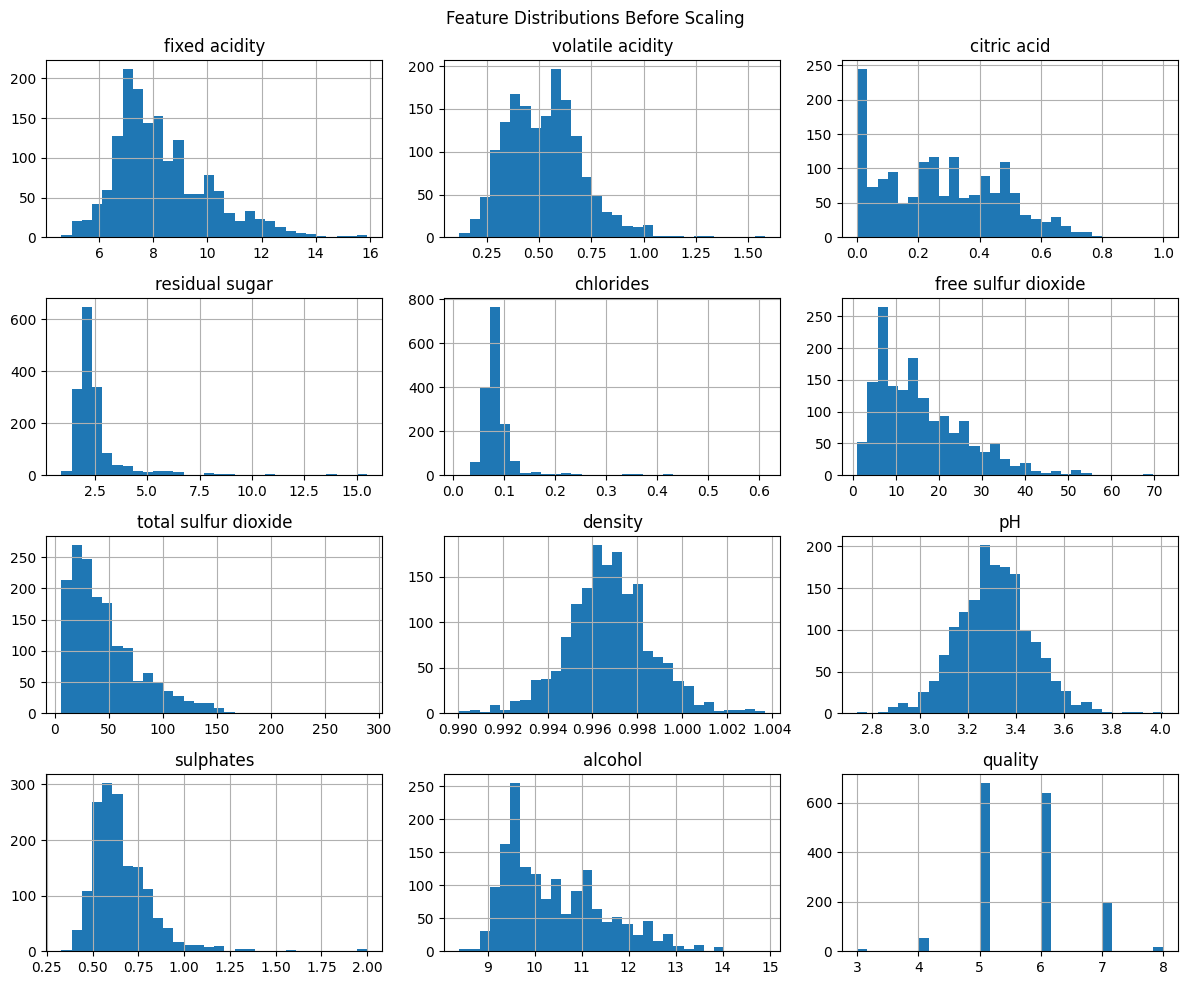

2025-05-22 14:20:29,775 : INFO : 3149788957 : Scaled features mean:
fixed acidity           3.554936e-16
volatile acidity        1.733031e-16
citric acid            -8.887339e-17
residual sugar         -1.244227e-16
chlorides               2.132961e-16
free sulfur dioxide    -6.221137e-17
total sulfur dioxide    4.443669e-17
density                -3.473172e-14
pH                      2.861723e-15
sulphates               6.754377e-16
alcohol                 1.066481e-16
quality                 5.636023e+00
dtype: float64
2025-05-22 14:20:29,781 : INFO : 3149788957 : Scaled features std dev:
fixed acidity           1.000313
volatile acidity        1.000313
citric acid             1.000313
residual sugar          1.000313
chlorides               1.000313
free sulfur dioxide     1.000313
total sulfur dioxide    1.000313
density                 1.000313
pH                      1.000313
sulphates               1.000313
alcohol                 1.000313
quality                 0.807569
dtype:

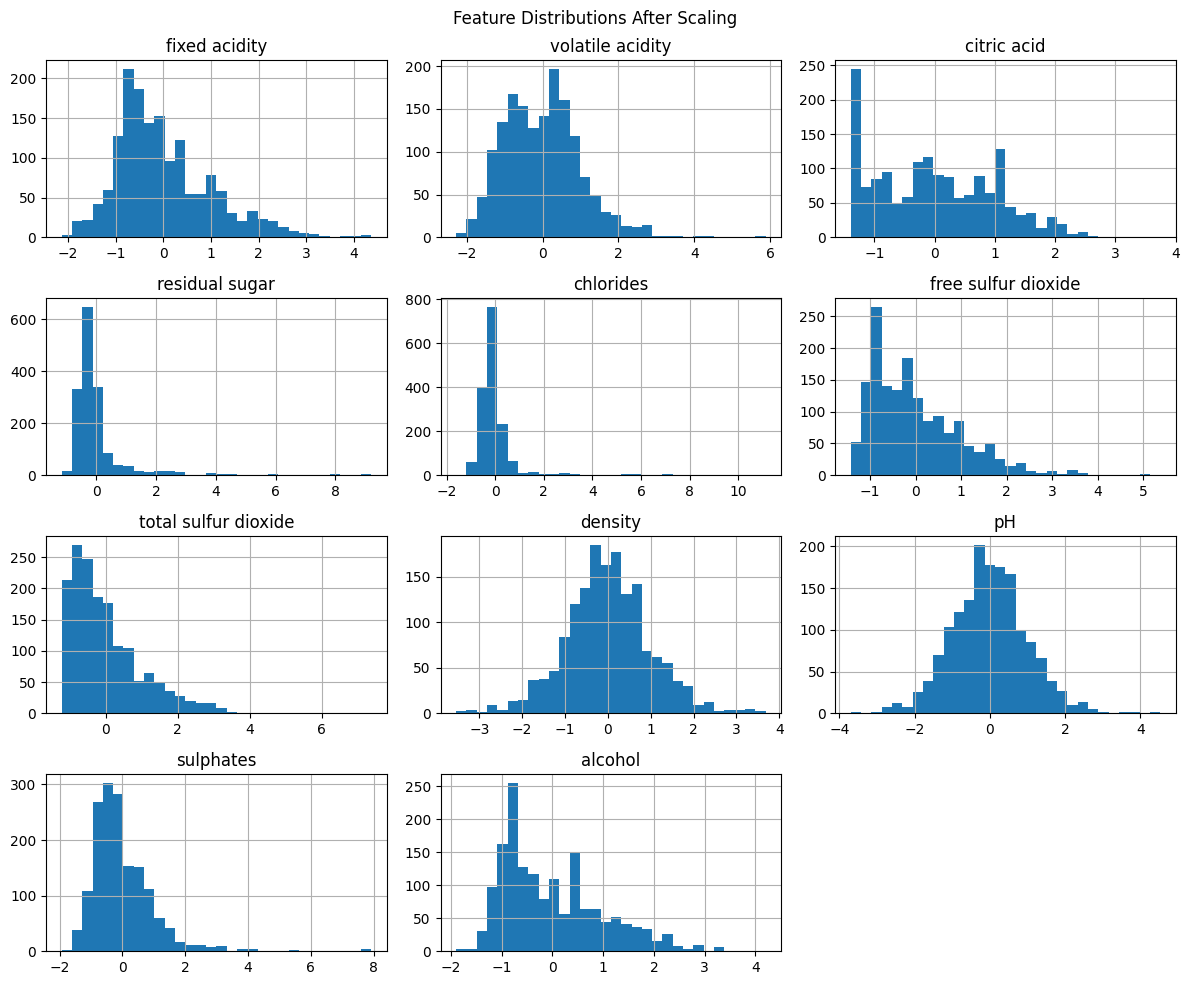

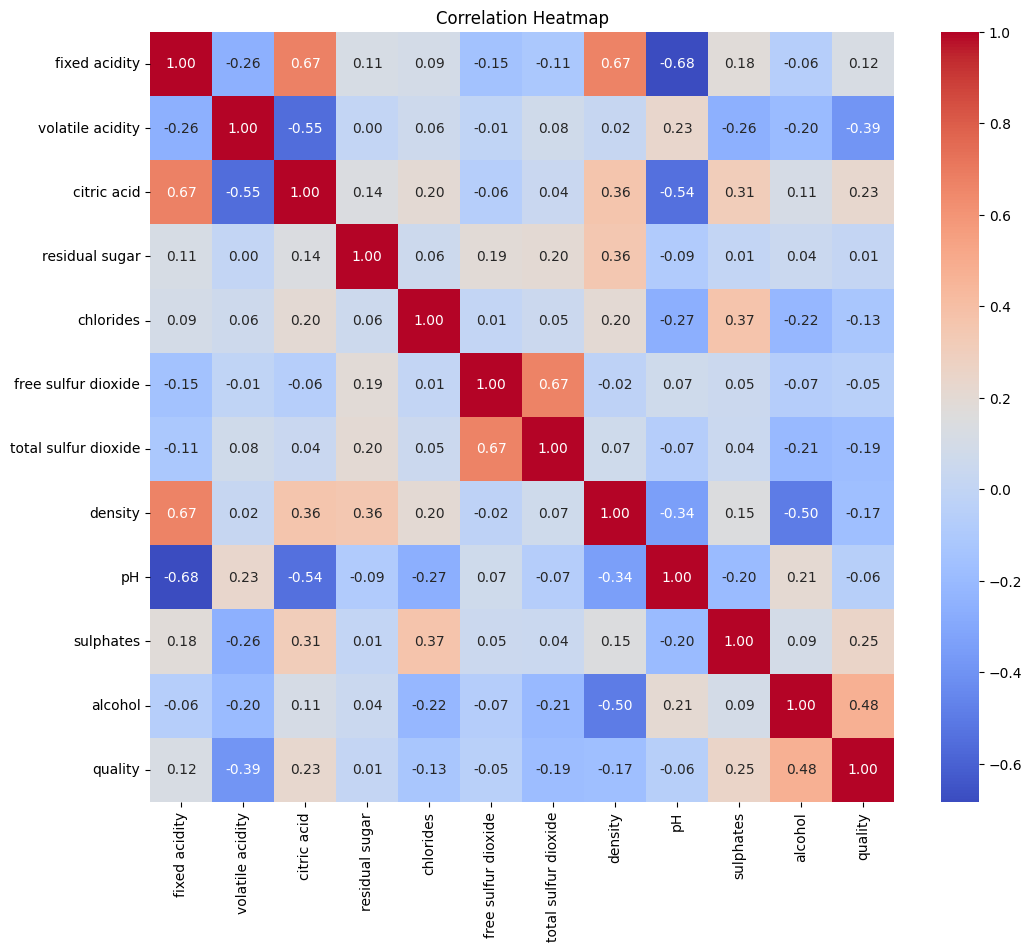

2025-05-22 14:20:34,192 : INFO : 3149788957 : Splited data into training and test sets
2025-05-22 14:20:34,193 : INFO : 3149788957 : (1279, 12)
2025-05-22 14:20:34,194 : INFO : 3149788957 : (320, 12)
(1279, 12)
(320, 12)


In [69]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.CheckEda()
    data_transformation.train_test_spliting()
except Exception as e:
    raise e